In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [55]:
# Function gets the energy based on a sphere of radius radius_threshold
def GetBlobEnergyRadius(parts_elec, hits_all, end, radius_threshold):
    
    # Get coordinates if the start/end
    if (end == "start"):
        start_coord = parts_elec[['initial_x', 'initial_y', 'initial_z']].values
    else:
        start_coord = parts_elec[['final_x', 'final_y', 'final_z']].values

    # Calculate the Euclidean distance from each row
    distances = np.sqrt(((hits_all[['x', 'y', 'z']].values[:, None] - start_coord) ** 2).sum(axis=2))

    # Find rows where any distance is within the threshold, then sum their energy
    mask = (distances < radius_threshold).any(axis=1)
    result = hits_all[mask]
    return result.energy.sum()


def SortBlobs(blob1_E, blob2_E):

    if (blob1_E > blob2_E):
        return blob1_E, blob2_E
    else:
        return blob2_E, blob1_E


def GetPrimaryKE(parts, hits, particle_id):

    primary_E = hits[hits.particle_id == particle_id].energy.sum()

    daugter_pids = parts[ (parts.mother_id == particle_id) & (parts.kin_energy < 0.1)].particle_id.unique()
    # display(parts)

    for daughter in daugter_pids:
        daugher_E = hits[hits.particle_id == daughter].energy.sum()
        primary_E = primary_E+daugher_E

    return primary_E


def CalcTrackExtent(hits):

    diff = hits.groupby('event_id').agg({
        'x': lambda x: x.max() - x.min(),
        'y': lambda y: y.max() - y.min(),
        'z': lambda z: z.max() - z.min()
    }).reset_index()

    # Rename columns
    diff.rename(columns={'x': 'dx', 'y': 'dy', 'z': 'dz'}, inplace=True)

    diff["Diam"] = np.sqrt((diff.dx)**2 + (diff.dy)**2 + (diff.dz)**2)

    return diff["Diam"]



In [61]:
# load in the particles table

pressure = 1

# parts_0nubb = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_nexus_1.h5", "MC/particles")
# hits_0nubb  = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_nexus_1.h5", "MC/hits")

# parts_Bkg = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_nexus_2954.h5", "MC/particles")
# hits_Bkg  = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_nexus_2954.h5", "MC/hits")

# display(parts_Bkg)


parts_Bkg = pd.read_hdf(f"/Users/mistryk2/Packages/nexus/workdir/XeSphere/XeSphere_1bar.h5", "MC/particles")
hits_Bkg  = pd.read_hdf(f"/Users/mistryk2/Packages/nexus/workdir/XeSphere/XeSphere_1bar.h5", "MC/hits")


def GetTrueInfoSignal(parts, hits):

    lengths  = []
    energies = []
    blob1_Es = []
    blob2_Es = []


    for eid in parts.event_id.unique():

        print("\n\n On event:", eid)

        part_event = parts[parts.event_id == eid]
        hits_event = hits[hits.event_id == eid]
        electron1  = part_event[part_event.particle_id == 1]
        electron2  = part_event[part_event.particle_id == 2]

        electron1_E = hits_event[hits_event.particle_id == 1].energy.sum()
        electron2_E = hits_event[hits_event.particle_id == 2].energy.sum()

        length = electron1.length.iloc[0]     + electron2.length.iloc[0] # total length

        tot_KE = GetPrimaryKE(part_event, hits_event, 1) +  GetPrimaryKE(part_event, hits_event, 2)
        # tot_KE = electron1_E + electron2_E # total energy

        blob1_E =  GetBlobEnergyRadius(electron1, hits_event, "end", 180/pressure)
        blob2_E =  GetBlobEnergyRadius(electron2, hits_event, "end",   180/pressure)

        print("Length:", length, "mm")
        print("Tot Energy:", tot_KE, "MeV")
        print("Blob1 Energy:", blob1_E, "MeV")
        print("Blob2 Energy:", blob2_E, "MeV")

        lengths.append(length)
        energies.append(tot_KE)
        blob1_Es.append(blob1_E)
        blob2_Es.append(blob2_E)

    TrackDiam = CalcTrackExtent(hits_event[ (hits_event.particle_id == 1) | (hits_event[hits_event.particle_id == 2) ] )

    return lengths, energies, blob1_Es, blob2_Es, TrackDiam


def GetTrueInfoBackground(parts, hits):

    lengths  = []
    energies = []
    blob1_Es = []
    blob2_Es = []


    for eid in parts.event_id.unique():

        # print("\n\n On event:", eid)

        part_event = parts[parts.event_id == eid]

        # Here we get the row with the largest electron energy and call that the primary
        part_event = part_event[part_event.particle_name == "e-"]
        parts_primary = part_event.loc[[part_event['kin_energy'].idxmax()]]
        primary_part_id = parts_primary.particle_id.iloc[0]
        
        hits_event = hits[hits.event_id == eid]
        electron1  = part_event[part_event.particle_id == primary_part_id]

        tot_KE = GetPrimaryKE(part_event, hits_event, primary_part_id)
        # tot_KE = hits_event[hits_event.particle_id == primary_part_id].energy.sum()

        length = electron1.length.iloc[0] # total length

        blob1_E =  GetBlobEnergyRadius(electron1, hits_event, "start", 180/pressure)
        blob2_E =  GetBlobEnergyRadius(electron1, hits_event, "end",   180/pressure)
        blob1_E, blob2_E = SortBlobs(blob1_E, blob2_E) # Make sure the blohE are labelled properly

        # print("Length:", length, "mm")
        # print("Tot Energy:", tot_KE, "MeV")
        # print("Blob1 Energy:", blob1_E, "MeV")
        # print("Blob2 Energy:", blob2_E, "MeV")

        lengths.append(length)
        energies.append(tot_KE)
        blob1_Es.append(blob1_E)
        blob2_Es.append(blob2_E)

    TrackDiam = CalcTrackExtent(hits_event[ hits_event.particle_id == primary_part_id])

    return lengths, energies, blob1_Es, blob2_Es, TrackDiam


# lengths, energies, blob1_Es, blob2_Es, TrackDiam = GetTrueInfoSignal(parts_0nubb, hits_0nubb)

lengths, energies, blob1_Es, blob2_Es, TrackDiam = GetTrueInfoBackground(parts_Bkg, hits_Bkg)



SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1224541706.py, line 56)

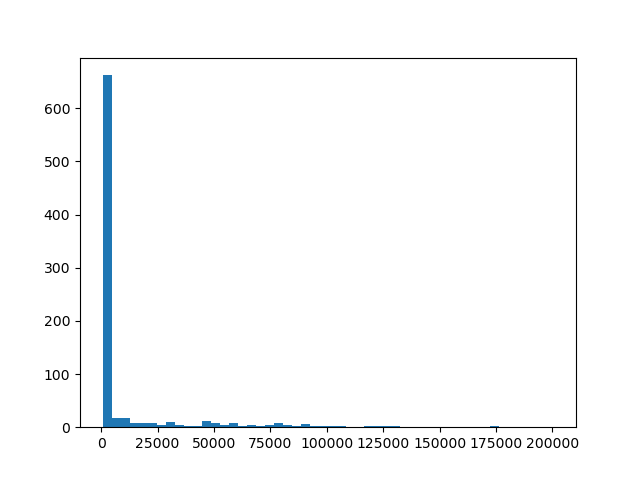

In [59]:
plt.figure()

plt.hist(TrackDiam, bins = 50);


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5506/3418201900.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


1.379684
[143 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126
 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108
 107 106 105 104 103 102 101 100  99  98  97  96  95  94  93  92  91  90
  89  88  87  86  85  84  83  82  81  80  79  78  77  76  75  74  73  72
  71  70  69  68  67  66  65  64  63  62  61  60  59  58  57  56  55  54
  53  52  51  50  49  48  47  46  45  44  43  42  41  40  39  38  37  36
  35  34  33  32  31  30  29  28  27  26  25  24  23  22  21  20  19  18
  17  16  15  14  13  12  11  10   9   8   7   6   5   4   3   2]
2.2686865


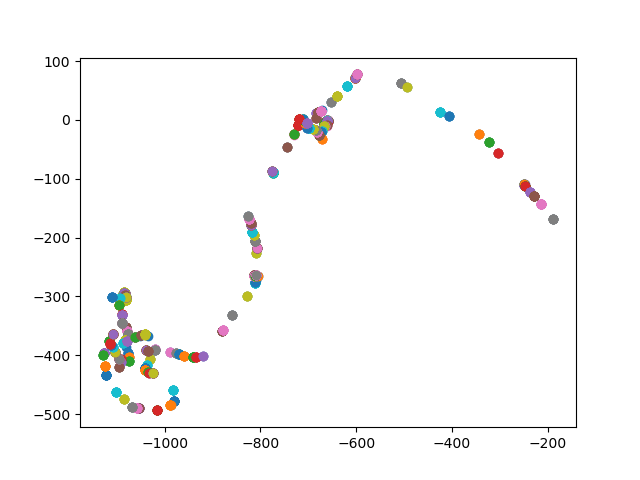

In [29]:
plt.figure()

events = hits_Bkg.event_id.unique()
event = hits_Bkg[hits_Bkg.event_id == events[1]]

# display(event.particle_id.unique())

print(event[event.particle_id == 1].energy.sum())

print( GetPrimaryKE(parts_Bkg[parts_Bkg.event_id == events[1]], event, 1))

for p in event.particle_id.unique():
    
    plt.scatter(event[event.particle_id==p].x, event[event.particle_id==p].y)


